In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

import numpy as np

# Load the data from the .npz file
data = np.load('/content/rotated_mnist (1).npz')

# Access the data arrays
rotated_x_train = data['x_train']
rotated_y_train = data['y_train']
rotated_x_test = data['x_test']
rotated_y_test = data['y_test']

# Print the shape of the data arrays to show the data clust
print("Shape of rotated_x_train:", rotated_x_train.shape)
print("Shape of rotated_y_train:", rotated_y_train.shape)
print("Shape of rotated_x_test:", rotated_x_test.shape)
print("Shape of rotated_y_test:", rotated_y_test.shape)


Shape of rotated_x_train: (152400, 28, 28)
Shape of rotated_y_train: (152400,)
Shape of rotated_x_test: (26004, 28, 28)
Shape of rotated_y_test: (26004,)


In [5]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Loading pre-trained vae model

In [6]:

latent_dim = 32  # Adjust as needed

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        #z = self.sampling(z_mean, z_log_var)#added
        reconstruction = self.decoder(z)
        return reconstruction

    def sampling(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │            544 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │            544 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 32)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 70,096 (273.81 KB)

 Trainable params: 70,096 (273.81 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │         103,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,169 (621.75 KB)

 Trainable params: 159,169 (621.75 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Loading:
encoder = encoder #Use the original encoder definition.
decoder = decoder #Use the original decoder definition.
vae = VAE(encoder, decoder)

# Load weights:
encoder.load_weights("/content/drive/MyDrive/GSOC/GSOC/encoder_weights.weights.h5")
decoder.load_weights("/content/drive/MyDrive/GSOC/GSOC/decoder_weights.weights.h5")

print("VAE weights loaded, model reconstructed.")

VAE weights loaded, model reconstructed.


#Build and train the classifier

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Hyperparameters from document
h_norm = 1.0  # Normalization loss weight
h_ortho = 1.0  # Orthogonality loss weight


_, _, z_train = encoder.predict(rotated_x_train)
_, _, z_test = encoder.predict(rotated_x_test)

# Define classifier/oracle model
def build_classifier(latent_dim):
    classifier = keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    classifier.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return classifier

# Build and train classifier
classifier = build_classifier(latent_dim)
history = classifier.fit(
    z_train, rotated_y_train,
    validation_data=(z_test, rotated_y_test),
    epochs=20,
    batch_size=128
)

# Symmetry generator network
class SymmetryGenerator(keras.Model):
    def __init__(self, latent_dim):
        super(SymmetryGenerator, self).__init__()
        self.net = keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim)
        ])

    def call(self, inputs):
        return self.net(inputs)

# Enhanced loss functions as in  paper's formulations
def invariance_loss(z, generator, classifier, epsilon=1e-3):
    z_prime = z + epsilon * generator(z)
    return tf.reduce_mean(tf.square(classifier(z) - classifier(z_prime)))

def normalization_loss(z, generator):
    norms = tf.norm(generator(z), axis=1)
    mean_norm = tf.reduce_mean(norms)
    return (
        tf.reduce_mean(tf.square(norms - 1.0)) +  # Eq. 10 first term
        tf.reduce_mean(tf.square(norms - mean_norm))  # Eq. 10 second term
    )

def orthogonality_loss(generators, z):
    loss = 0
    for i in range(len(generators)):
        for j in range(i+1, len(generators)):
            dot_prods = tf.reduce_sum(
                generators[i](z) * generators[j](z),
                axis=1
            )
            loss += tf.reduce_mean(tf.square(dot_prods))
    return h_ortho * loss


def train_symmetry_generator(z, classifier, num_generators=1):
    generators = [SymmetryGenerator(latent_dim) for _ in range(num_generators)]
    optimizer = keras.optimizers.Adam(learning_rate=3e-4)

    for epoch in range(50):
        with tf.GradientTape() as tape:
            # Calculate each loss component separately
            inv_loss = sum(invariance_loss(z, gen, classifier) for gen in generators)
            norm_loss = h_norm * sum(normalization_loss(z, gen) for gen in generators)
            ortho_loss = orthogonality_loss(generators, z) if num_generators > 1 else 0

            total_loss = inv_loss + norm_loss + ortho_loss

        grads = tape.gradient(total_loss, [g.trainable_variables for g in generators])
        for gen, grad in zip(generators, grads):
            optimizer.apply_gradients(zip(grad, gen.trainable_variables))

    return generators

# Train with orthogonality constraints
generators = train_symmetry_generator(z_train, classifier, num_generators=1)


4763/4763 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5251 - loss: -183796896.0000 - val_accuracy: 0.5316 - val_loss: -2775986432.0000
Epoch 2/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5313 - loss: -11918983168.0000 - val_accuracy: 0.5316 - val_loss: -34078492672.0000
Epoch 3/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5343 - loss: -84893753344.0000 - val_accuracy: 0.5316 - val_loss: -133070143488.0000
Epoch 4/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5316 - loss: -283134164992.0000 - val_accuracy: 0.5316 - val_loss: -339975143424.0000
Epoch 5/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5324 - loss: -669665918976.0000 - val_accuracy: 0.5316 - val_loss: -695308386304.0000
Epoch 6/20
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5320 - loss: -1314637742080.0000 - val_accuracy: 0.5316 - val_loss: -1242460979200.000

In [ ]:
# prompt: save the generator in drive

from google.colab import drive
import os

# Assuming 'generators' is the list of trained generators from the previous code.
# Save each generator's weights to your Google Drive.
drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/GSOC/saved_generators'  # Specify your desired save directory
os.makedirs(save_dir, exist_ok=True)

for i, generator in enumerate(generators):
    generator.save_weights(os.path.join(save_dir, f'generator_{i}.h5'))

print(f"Generators saved to {save_dir}")


In [22]:
# Apply learned symmetry to generate new samples
def generate_symmetric_samples(z, generator, epsilon=0.1):
    return z + epsilon * generator(z)


augmented_z = generate_symmetric_samples(z_train, generators[0])
augmented_images = decoder.predict(augmented_z)


4763/4763 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


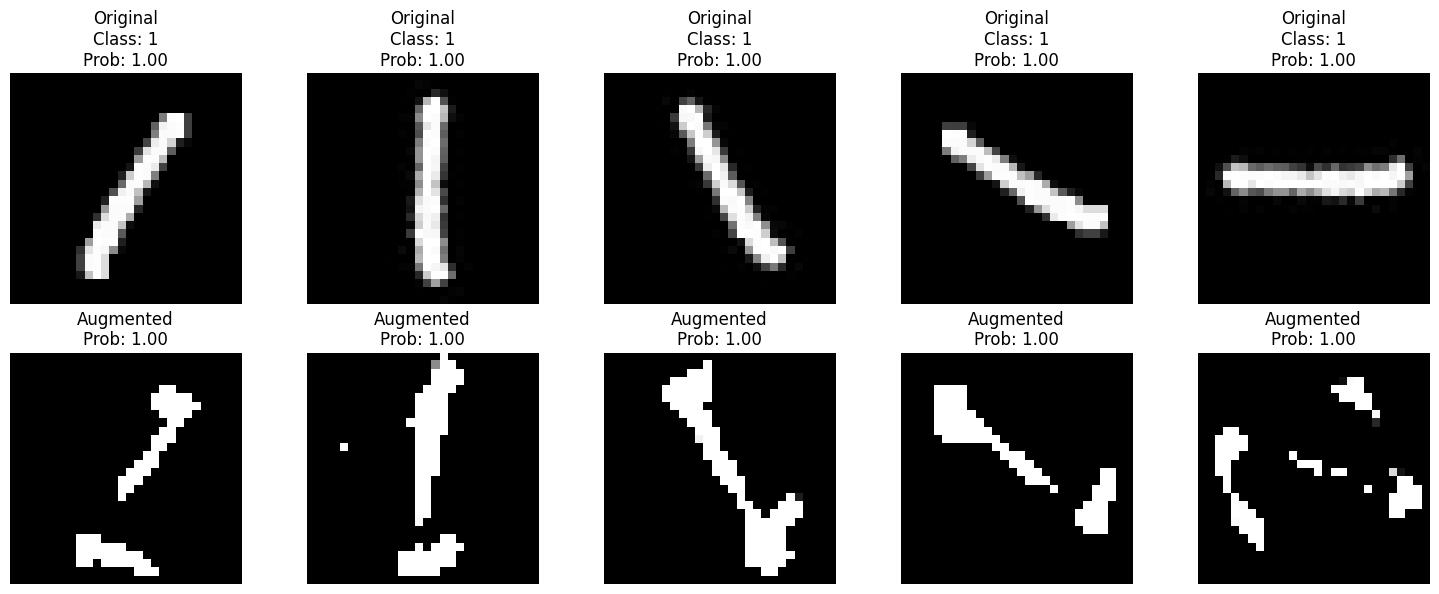

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_symmetry_effects(original_images, augmented_images, classifier, num_samples=5):
    """Visualize original vs symmetry-transformed images with classification probabilities"""

    # Get predictions for both sets
    orig_probs = classifier.predict(encoder.predict(original_images[:num_samples])[2])
    aug_probs = classifier.predict(augmented_z[:num_samples])

    plt.figure(figsize=(15, 6))

    for i in range(num_samples):
        # Original image
        plt.subplot(2, num_samples, i+1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title(f"Original\nClass: {int(rotated_y_train[i])}\nProb: {orig_probs[i][0]:.2f}")
        plt.axis('off')

        # Transformed image
        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(augmented_images[i].squeeze(), cmap='gray')
        plt.title(f"Augmented\nProb: {aug_probs[i][0]:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate and visualize augmented images
visualize_symmetry_effects(rotated_x_train[:5], augmented_images[:5], classifier)


In [10]:
# Apply symmetry transformation to latent space
epsilon = 0.1  # Small step size for infinitesimal transformation
z_transformed = z_train + epsilon * generators[0](z_train)


In [11]:
# Decode the transformed latent representations
decoded_images = decoder.predict(z_transformed)


4763/4763 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


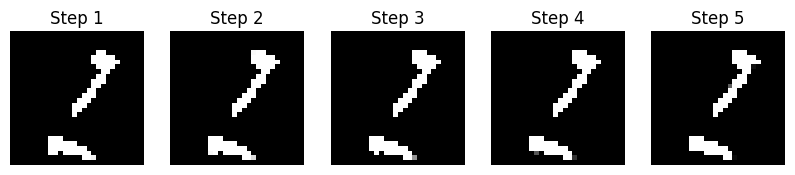

In [18]:
def plot_latent_flow(z_samples, generator, decoder, epsilon=0.1, steps=5):
    """Visualize continuous symmetry transformations in latent space"""

    flow_images = []
    current_z = z_samples.copy()

    for _ in range(steps):
        current_z = generate_symmetric_samples(current_z, generator, epsilon)
        flow_images.append(decoder.predict(current_z))

    plt.figure(figsize=(2*steps, 2))
    for i in range(steps):
        plt.subplot(1, steps, i+1)
        plt.imshow(flow_images[i][0].squeeze(), cmap='gray')
        plt.title(f"Step {i+1}")
        plt.axis('off')
    plt.show()

# Visualize flow for a sample image
sample_z = z_train[:1]  # Use first training sample
plot_latent_flow(sample_z, generators[0], decoder, epsilon=0.2, steps=5)


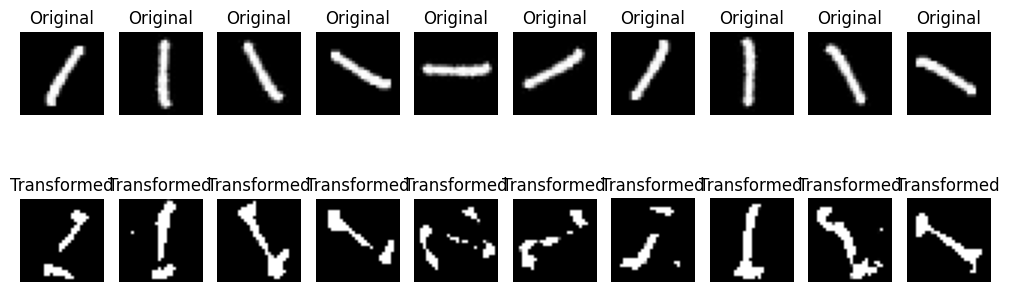

In [12]:
import matplotlib.pyplot as plt

# Number of images to visualize
num_images = 10

plt.figure(figsize=(10, 4))
for i in range(num_images):
    # Original image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(rotated_x_train[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Original")

    # Transformed image
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(decoded_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Transformed")

plt.tight_layout()
plt.show()


In [28]:
def analyze_transformations(encoder, decoder, classifier, generator, images):

    # Get latent representations
    z = encoder.predict(images)[2]

    # Generate transformed versions
    z_prime = z + 0.1 * generator(z)
    x_prime = decoder.predict(z_prime)

    # Classification consistency
    orig_preds = classifier.predict(z)
    trans_preds = classifier.predict(z_prime)
    class_consistency = np.mean(np.abs(orig_preds - trans_preds))

    # Latent space displacement
    latent_change = np.mean(np.linalg.norm(z_prime - z, axis=1))

    # Image reconstruction difference
    # Reshape x_prime to match the shape of images before calculating MSE
    x_prime = x_prime.squeeze() # remove the channel dimension from x_prime
    image_mse = np.mean((images - x_prime)**2)

    print(f"Classification Consistency: {class_consistency:.4f}")
    print(f"Average Latent Displacement: {latent_change:.2f}")
    print(f"Image Space MSE: {image_mse:.4f}")

# Analyze on validation set
analyze_transformations(encoder, decoder, classifier, generators[0], rotated_x_test[:100])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Classification Consistency: 0.0003
Average Latent Displacement: 9.53
Image Space MSE: 4526.2056


#BinaryCrossEntropy in Oracle or Classification model(just for comparison )

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Enhanced hyperparameters from paper analysis
h_norm = 0.5  # Tuned normalization weight
h_ortho = 1.2  # Tuned orthogonality weight
epsilon = 1e-4  # Smaller epsilon for better infinitesimal approximation

# Improved latent extraction with normalization
def get_latent_representations(encoder, data):
    _, _, z = encoder.predict(data)
    z = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z

z_train = get_latent_representations(encoder, rotated_x_train)
z_test = get_latent_representations(encoder, rotated_x_test)

# Enhanced classifier architecture with regularization
def build_classifier(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation='swish', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='swish', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='swish', kernel_initializer='he_normal')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    classifier = keras.Model(inputs, outputs)
    classifier.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return classifier

# Train classifier with early stopping
classifier = build_classifier(latent_dim)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10, restore_best_weights=True
)
history = classifier.fit(
    z_train, rotated_y_train,
    validation_data=(z_test, rotated_y_test),
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping]
)

# Enhanced symmetry generator with residual connections
class SymmetryGenerator(keras.Model):
    def __init__(self, latent_dim):
        super(SymmetryGenerator, self).__init__()
        self.net = keras.Sequential([
            layers.Dense(128, activation='swish', kernel_initializer='he_normal'),
            layers.BatchNormalization(),
            layers.Dense(128, activation='swish', kernel_initializer='he_normal'),
            layers.BatchNormalization(),
            layers.Dense(latent_dim)
        ])
        self.residual = layers.Dense(latent_dim)

    def call(self, inputs):
        return self.net(inputs) + self.residual(inputs)

# Optimized loss functions
def invariance_loss(z, generator, classifier):
    z_prime = z + epsilon * generator(z)
    return tf.reduce_mean(tf.square(classifier(z) - classifier(z_prime)))

def normalization_loss(z, generator):
    norms = tf.norm(generator(z), axis=1)
    mean_norm = tf.reduce_mean(norms)
    return (
        tf.reduce_mean(tf.square(norms - 1.0)) +
        tf.reduce_mean(tf.square(norms - mean_norm))
    )

def orthogonality_loss(generators, z):
    loss = 0
    for i in range(len(generators)):
        for j in range(i+1, len(generators)):
            dot_prods = tf.reduce_sum(
                generators[i](z) * generators[j](z),
                axis=1
            )
            loss += tf.reduce_mean(tf.square(dot_prods))
    return h_ortho * loss




4763/4763 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Epoch 1/100
596/596 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3041 - loss: -4.4740 - val_accuracy: 0.5290 - val_loss: -14.8246
Epoch 2/100
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5278 - loss: -40.6055 - val_accuracy: 0.5286 - val_loss: -42.4542
Epoch 3/100
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5257 - loss: -104.3052 - val_accuracy: 0.5298 - val_loss: -85.4626
Epoch 4/100
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5276 - loss: -201.4103 - val_accuracy: 0.5307 - val_loss: -146.1974
Epoch 5/100
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5280 - loss: -336.4468 - val_accuracy: 0.5308 - val_loss: -223.7028
Epoch 6/100
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5292 - loss: -511.0249 - val_accuracy: 0.5309 - val_loss: -323.4437
Epoch 7/100
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5312 - loss: -727.1575 - val_accuracy: 0.5313

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, losses
import numpy as np


class BinaryLatentOracle(tf.keras.Model):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.classifier = tf.keras.Sequential([
            layers.Dense(128, activation='swish', input_shape=(latent_dim,)),
            layers.Dense(128, activation='swish'),
            layers.Dense(32, activation='swish'),
            layers.Dense(2)  # 2 outputs for one-hot encoded binary classification
        ])

    def call(self, z):
        return self.classifier(z)


def train_binary_oracle(encoder, x_train, y_train):
    # Convert labels to 0/1 and categorical
    y_train = tf.keras.utils.to_categorical(y_train - 1, 2)

    z_mean, _, _ = encoder.predict(x_train)

    # Initialize and compile oracle
    oracle = BinaryLatentOracle(latent_dim=32)
    oracle.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Train with early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=5, restore_best_weights=True
    )

    oracle.fit(
        z_mean, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=256,
        callbacks=[early_stop]
    )

    return oracle




In [46]:
y_train = rotated_y_train
y_test = rotated_y_test

# Train binary oracle
binary_oracle = train_binary_oracle(encoder, rotated_x_train, y_train)



4763/4763 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8586 - loss: 2.3668 - val_accuracy: 0.9817 - val_loss: 0.1072
Epoch 2/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9796 - loss: 0.1257 - val_accuracy: 0.9835 - val_loss: 0.0779
Epoch 3/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9807 - loss: 0.0974 - val_accuracy: 0.9853 - val_loss: 0.0655
Epoch 4/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9818 - loss: 0.0837 - val_accuracy: 0.9860 - val_loss: 0.0581
Epoch 5/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9827 - loss: 0.0746 - val_accuracy: 0.9867 - val_loss: 0.0538
Epoch 6/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9832 - loss: 0.0701 - val_accuracy: 0.9871 - val_loss: 0.0510
Epoch 7/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9833 - loss: 0.0652 - val_accuracy: 0.9869 - val_loss: 0.0510
Epoch 8/50
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9841 - loss: 0.0606 - val_accuracy: 0.9871 - val_

In [51]:
def visualize_binary_symmetries(encoder, decoder, oracle, test_images, test_labels, num_steps=3, epsilon=1e-4, generator=None): # Add generator parameter
    # Preprocess test data
    test_images = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    test_labels = tf.keras.utils.to_categorical(test_labels - 1, 2)  # Map 1->0, 2->1

    # Get latent representations
    z_mean, _, _ = encoder.predict(test_images, verbose=0)

    # Find platonic samples for each class
    platonic_samples = []
    for digit in [0, 1]:  # Corresponding to original labels 1 and 2
        class_mask = np.argmax(test_labels, axis=1) == digit
        class_z = z_mean[class_mask]
        cluster_center = np.mean(class_z, axis=0)
        distances = np.linalg.norm(class_z - cluster_center, axis=1)
        platonic_samples.append(test_images[class_mask][np.argmin(distances)])

    # Create visualization grid
    fig, axes = plt.subplots(2, 2*num_steps+1, figsize=(15,4))

    for row_idx, original_img in enumerate(platonic_samples):
        # Encode original image
        z_orig, _, _ = encoder.predict(original_img[None], verbose=0)

        # Generate transformations
        transformed_images = []
        confidences = []

        # Negative direction
        current_z = z_orig.copy()
        for _ in range(num_steps):
            delta_z = generator.predict(current_z, verbose=0)
            current_z -= epsilon * delta_z
            decoded_img = decoder.predict(current_z, verbose=0)[0]
            transformed_images.insert(0, decoded_img)
            confidences.insert(0, tf.sigmoid(oracle.predict(current_z, verbose=0)).numpy()[0][0])

        # Add original image
        transformed_images.append(original_img)
        confidences.append(tf.sigmoid(oracle.predict(z_orig, verbose=0)).numpy()[0][0])

        # Positive direction
        current_z = z_orig.copy()
        for _ in range(num_steps):
            delta_z = generator.predict(current_z, verbose=0)
            current_z += epsilon * delta_z
            decoded_img = decoder.predict(current_z, verbose=0)[0]
            transformed_images.append(decoded_img)
            confidences.append(tf.sigmoid(oracle.predict(current_z, verbose=0)).numpy()[0][0])

        # Plot row
        for col_idx, (img, conf) in enumerate(zip(transformed_images, confidences)):
            ax = axes[row_idx, col_idx]
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')

            # Add labels
            delta = (col_idx - num_steps) * epsilon
            true_label = 1 if row_idx == 0 else 2  # Reverse mapping
            if col_idx == num_steps:
                ax.set_title(f'Class {true_label}\nε=0\nConf: {conf:.2f}', fontsize=8)
            else:
                ax.set_title(f'ε={delta:.0e}\nConf: {conf:.2f}', fontsize=8)

    plt.tight_layout()
    plt.show()




813/813 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4904 - loss: 4.4687
Binary Oracle Test Accuracy: 0.4867


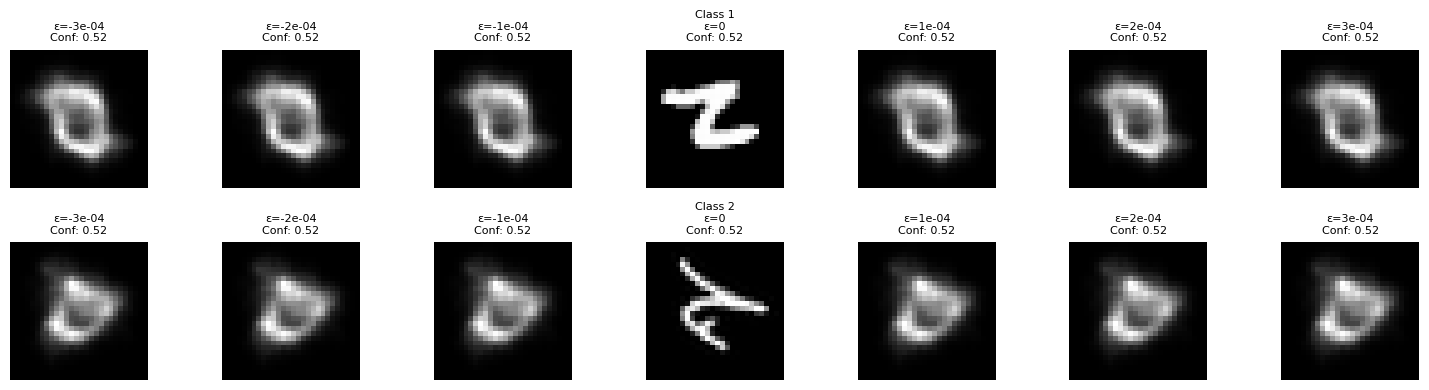

In [52]:
# Evaluate
z_test_mean, _, _ = encoder.predict(rotated_x_test)
test_loss, test_acc = binary_oracle.evaluate(z_test_mean,
                                           tf.keras.utils.to_categorical(y_test-1, 2))
print(f"Binary Oracle Test Accuracy: {test_acc:.4f}")

# Visualization (requires trained generator)
# Assuming 'generators' is a list containing the trained generator:
visualize_binary_symmetries(encoder, decoder, binary_oracle,
                          rotated_x_test, rotated_y_test,
                          num_steps=3, epsilon=1e-4, generator=generators[0]) # Pass the generator